# REAL1-CG.3135: Real Estate Data Science

## Classes 8 and 9

### More on Omitted Variable Bias: *Breaking Every Algorithm*
### An Introduction to Machine Learning, Classification and *Unsupervised Learning*

In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt  
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
import theano
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
from pylab import get_cmap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.datasets import mnist

from PIL import Image
import urllib.request as url
import io
from IPython.display import Image

Using TensorFlow backend.


### Omitted Variable Bias (Continued)
* **What cannot be measured, cannot be included**.  
    * No algorithm can compensate.
    * What is excluded may be more relevant than what is included.
    * GIGO.



* CAPM provides us with a valid application of linear regression and hypothesis testing.
    * It is grounded in financial theory (modern portfolio theory) and remains a workhorse model in finance.
    * Its extension to additional factors was not driven by basic theory.
    * It was driven by a "better model".
    * In empirical economics, it takes a model to beat a model.
    
    

* In CRE, we measure value through imputation of cap rates.  
    * A simple correlation of cap rates and U.S. Treasuries provides an inaccurate measure.
    * Arguably, holding all else constant, the correlation should be positive.  
    * Failing to include **all else** forces the algorithm to asset only the affect of changes in Treasuries.
        * And it is wrong: we have *broken the algorithm*.
    * Often, we have only **proxy measures** of features that we would want to measure.  Remember the CBRE Cap Rate model: **QE was a proxy**.



* We will explore the idea using both Monte Carlo simulation methods and a specific example, *the returns to education*.

## The Returns to Education: ROI on Human Capital

### Overview: The Early Days

> “Those talents, as they make a part of his fortune, so do they likewise that of the society to which he belongs. The improved dexterity of a workman may be considered in the same light as a machine or instrument of trade which facilitates and abridges labor, and which, though it costs a certain expense, repays that expense with a profit.”

> Adam Smith, *The Wealth of Nations*, 1776

### Human Capital

+ Human capital (as opposed to physical or financial capital) comprises the abilities, knowledge, education, and other attributes that individuals bring to the labor market.
+ In exchange for their labor to produce economic value in a marketplace, individuals receive wages (or earnings).
+ Strong focus on the development of capital through education and workforce experience. 
    * Is is possible to measure the ROI on education?
    * Large topic in labor economics.

### Wages

+ Economist Jacob Mincer specified an approach that relates observed wages to schooling and other measures of human capital, such as job market experience. 
+ Relation is typically expressed as the natural log of wages.  Wages are not normally distributed (no negative wages), but rather could be log-normally distributed.
    - The same applies to equity prices: prices are non-negative and returns may be normally distributed.
    - $ln(1+r) ≈ r$ for small $r$, so regression estimates can be viewed as rates of return.

In [2]:
import numpy as np

print(np.round(np.log(1 + 0.01), decimals = 4))
print(np.round(np.log(1 + 0.05), decimals = 4))
print(np.round(np.log(1 + 0.10), decimals = 4))

0.01
0.0488
0.0953


### The Returns to Education

* The goal is measure the **rate of return** or ROI to education.
    * Increase, if any, in earnings associated with an additional year of education.
* A simple correlation of wages and years of schooling does not necessarily accurately measure this relation.
    * Remember the CBRE Cap Rate model.
* Let’s look at the Griliches (1979) data.
    * Paper is [here](https://athens.src.uchicago.edu/jenni/dvmaster/FILES/griliches77f.pdf)

### Data Dictionary of Griliches Data
* lw: the natural log of 1980 earnings per hour.
* school: years of schooling.
* iq: measured intelligence quotient (IQ).
* age: age at time of measurement.
* expr: total job market experience.
* tenure: length of time on current job.
* med: mother's level of education. 

## The Linear Probability Model and the Logit

* It is trivial to extend our basic algoriithm to the so-called two-class outcome: {Off, On} or {Not Admit, Admit}.
    * More generally: {0, 1}.
    
    
* A visual will motivate the new use case.

In [3]:
random.seed(12345)
red = np.random.multivariate_normal([-1, 1], [[1,0],[0,1]], 1000)
blue = np.random.multivariate_normal([1, -1], [[1,0],[0,1]], 1000)
arr = np.concatenate((red, blue), axis=0)

Text(0.5, 1.0, 'A Scatterplot')

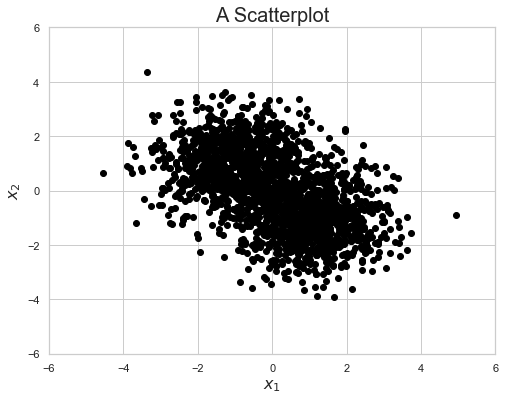

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(arr[0:999, 1], arr[0:999, 0], c="black")
plt.scatter(arr[1000:1999, 1],arr[1000:1999, 0], c="black")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot', fontsize = 20)

#### Notes

1. This scatterplot should be quite familiar by now.


2. We have two features, $(x_1, x_2)$, and some label, which could be **anything**.
    * A row in our dataframe (or Excel spreadsheet) could be [house prices, age, size].


3. Now imagine that the dots are **two flavors**, {red, blue}.
    * That is, a row in the dataframe contains three columns, a label and two features.
    * [flavor, $x_1$, $x_2$].  
    * For example, [red, -2, 2].

Text(0.5, 1.0, 'A Scatterplot with Red-Blue Labels')

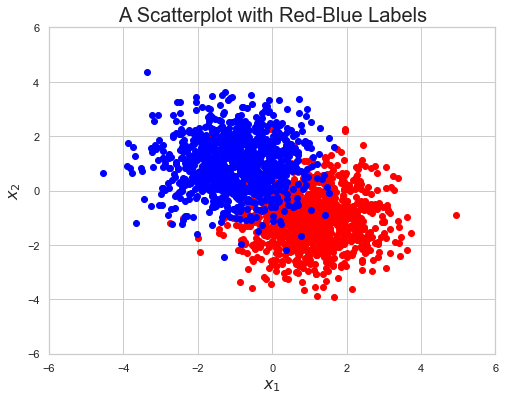

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(arr[0:999, 1], arr[0:999, 0], c="red")
plt.scatter(arr[1000:1999, 1],arr[1000:1999, 0], c="blue")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Red-Blue Labels', fontsize = 20)

### Notes
* Let's interpret the results from the linear probability model.
* GRE: Graduate Record Examine: a one point increase in GRE increases probability of admission by 0.0004 or 0.04%
* GPA: Grade Point Average: a one point increase in GPA increases probability of admission by 0.156 or 15.6%.
* rank: Going to a tier 2 school reduces probabilty of admission by 0.1624 or 16.24% (relative to a tier 1 school).


* The LPM can be used to predict.

### The Intellectual Motivation of the Logit: Latent Labels (or Variables)
* One can think of categorical variable as being driven by an underlying DGP.
    * As with time series, we do not observe the continuous process.
    * We observe realizations.



* Consider the now familiar DGP: $y_i^*=x_i^\prime\beta+\epsilon_i$



* $y_i^*$ is a latent value for person *i* that is **unobserved by us**.  
    * For example, you do not observe the value I place on turning on the light.  
    * You simply observe that the lights are turn on.  
    * In other words, you observe the outcome {Off, On} or {0, 1}.  



* Another example would be observing someone taking a taxi.  
    * You do not observe the value that someone places on the taxi ride.  You know that she has many alternative methods of transportation, all with varying values to her, but you observe the outcome of her choice.



* $x_i$ are a vector of features (or attributes or predictors or independent variables) that we observe.



* $\beta$ is a vector that measures how features affect the latent index, which we will estimate as we did the FF factors. 



* $\epsilon_i$ retains its status as our ignorance.  



**What then do we observe?**



${\displaystyle d_i = }$
$\left\{ \begin{array}{l l} 
{1} & \quad \text{if person i takes a cab, which happens when } y_i^*\ge0\\ 
{0} & \quad \text{if person i does not take a cab, which happens when } y_i^*\lt0 \\
\end{array} \right.$  




### The Logit
* Start with a sample of size, $N$.  We are going to change the linear model to the following *representation*:



$Pr(d_i=1)=x_i^\prime\beta+\epsilon_i$



* We will then impose a distributional assumption on $\epsilon_i$, namely that it is logistically distributed.



${\displaystyle Pr(d_i=1) = \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}}$ 



* We see immediately that this is NOT **a linear model** (that is, a model that is linear in $\beta$).



${\displaystyle Pr(d_i=0) = 1 - Pr(d_i=1) = 1 - \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)} = \frac{1}{1+\exp(x_i^\prime\beta)}}$



* An **odds ratio**:



${\displaystyle \frac{Pr(d_i=1)}{Pr(d_i=0)} = \frac{Pr(d_i=1)}{1 - Pr(d_i=1)} = \exp(x_i^\prime\beta)}$



* This implies that the log-odds ratio or **logit** is:



${\displaystyle \log\big(\frac{Pr(d_i=1)}{1 - Pr(d_i=1)}\big) = x_i^\prime\beta}$, which is linear in $\beta$.



* To address the estimation of the parameters of interest, we need to construct a likelihood function that we will tell the computer to optimize.  Start by constructing the likelihood for observation $i$:



* ${\displaystyle l_i = Pr(d_i=1)^{d_i}\cdot Pr(d_i=0)^{(1-d_i)}=\frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}^{d_1}\frac{1}{1+\exp(x_i^\prime\beta)}^{(1-d_i)}}$



* If we make some assumptions we can write:



${\displaystyle L = \prod_{i=1}^N l_i = \prod_{i=1}^N \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}^{d_1}\frac{1}{1+\exp(x_i^\prime\beta)}^{(1-d_i)}}$



* Goal is to tell the machine to maximize $L$ with respect to $\beta$ given the data we have. 
    * Remember: representation, optimization and evaluation.



* Once we have done that, we can make probabilistic predictions (or classifications).

## An Introduction to Machine Learning
* The phrase **machine learning** has become very popular since about 2010, as has the phrase **data science**.



* The phrase **statistical learning** is more accurate and incompassing.
    * Recall that every algorithm has three components.
    1. Representation
    2. Optimization
    3. Evaluation



* Key insight from our friends in computer science was evaluation.  Rather than use the entire dataframe of size $N$, randomly split the dataframe into two parts.
    * $N_1$: the training set
    * $N_2$: the test set
    * $\ni N_1+N_2=N$




### An Application: Classification of Emails or {Not Spam, Spam}
* This area of statistical learning is called **classification**.
    * We seek to train a predictor function, $pred$, for a label using $K$ features, $x$.
    * $y_i = pred(x_{i1}, ..., x_{iK})$.
* The **realization** of this predictor, given a feature set, is sometimes called **yhat** or $\hat{y}$.
    * The prediction is **always a probability**.

### The Confusion Matrix: The Application of Classical Hypothesis Testing to Machine Learning

* With a logit predictor, you can correctly predict a 1 or correctly predict 0.
* Obviously, you can incorrectly predict a 1 or incorrectly predict a 0.
* This is the basis of the confusion matrix, together with other measures of **accuracy**.

In [6]:
#from tabulate import tabulate

table = [[" ","0", "1"],["0", "TN", "FP"],["1", "FN", "TP"]]
print(tabulate(table, tablefmt="fancy_grid", numalign="center"))

╒═══╤════╤════╕
│   │ 0  │ 1  │
├───┼────┼────┤
│ 0 │ TN │ FP │
├───┼────┼────┤
│ 1 │ FN │ TP │
╘═══╧════╧════╛


* By **machine learning** canon:
    * Zeros are negatives, and ones are positives
    * Correctly predicting a 0 is a True Negative
    * Correctly predicting a 1 is a True Positive
    * Incorrectly predicting a 0 is a False Negative
    * Incorrectly predicting a 1 is a Fale Positive



* The True Positive Rate is TP / (TP + FN) and measures the rate of correctly classified spam emails



* The False Positive Rate is FP / (TN + FP) and measures the the rate of incorrectly classified spam emails



* The Accuary Rate is (TN + TP) / (TN + FP + FN + TP) and measures the overall accuracy rate of the classification algorithm

### An Insight from Our Friends in Computer Science
* Prediction not evaluation.
    * A spam filter.



* How?  Split a dataframe into two parts.
    * A **training set**.
    * A **test set**.
    * Representation, optimication and **evaluation**.



* Let the algorithm see one part of the data and test it on the part it does not see.
    * Train/Test Split.
    * Out of Sample Prediction.
    * Backtesting.
    * Direct evaluation.
    * The end of econometrics?  (Not yet: economists are remora.)



* We are still left with a decision: the discriminant threshold.
    * Consider the canonical example of hypothesis testing.  
    * The equivalent in computer science is the trade-off: too much spam or too few emails.

### Professor Campbell Harvey:  How to Predict a Recession
* Yield Curves Should Be Upward Sloping (see Geltner *et al.*)
    * **Expectations Theory**: Long-term rates are the sum of expected short-term rates
    * **Liquidiity Preference Theory**: Long-term investment is riskier than short-term investment
    


* Can a machine predict [a recovery?](https://faculty.fuqua.duke.edu/~charvey/Term_structure/Harvey.pdf)

## The Multiclass Problem and an Another Idea from Our Friends: 
### Use Decision Trees and *Average Many Models Together*

* A visual will motivate the use case.

In [7]:
random.seed(12345)
red = np.random.multivariate_normal([-1, 1], [[1,0],[0,1]], 1000)
blue = np.random.multivariate_normal([1, -1], [[1,0],[0,1]], 1000)
green = np.random.multivariate_normal([-2, -2], [[1,0],[0,1]], 1000)
y1 = np.zeros((len(red),), dtype=np.int) + 1
y2 = np.zeros((len(blue),), dtype=np.int) + 2
y3 = np.zeros((len(green),), dtype=np.int) + 3
y = np.append(y1, y2, axis=0)
y = np.append(y, y3, axis=0)
X = np.append(red, blue, axis=0)
X = np.append(X, green, axis=0)

Text(0.5, 1.0, 'A Scatterplot with Three Labels')

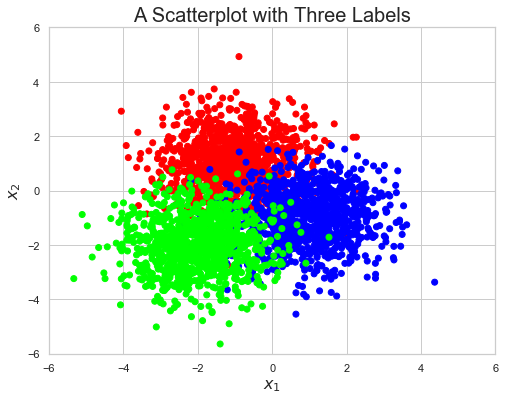

In [8]:
plt.figure(figsize = (8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Three Labels', fontsize = 20)

* This is a **multi-class** problem: the label has three types: {blue, green, red}.


* The core idea comes from **knowledge engineering**, an early effort at developing *artificial intelligence*.
    * Use decision true to create rules for classification.

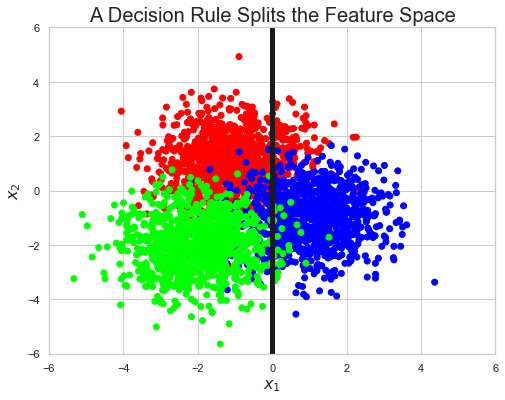

In [9]:
plt.figure(figsize = (8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Decision Rule Splits the Feature Space', fontsize = 20)
plt.axvline(x=0, linewidth=5, color='k')

* Split (or separate) the feature space at $x_1 = 0$.
    * Clear decision rule: any label with feature $x_1 >0$ declare to be **blue**.

* Now split the the feature space at x2 = 0.

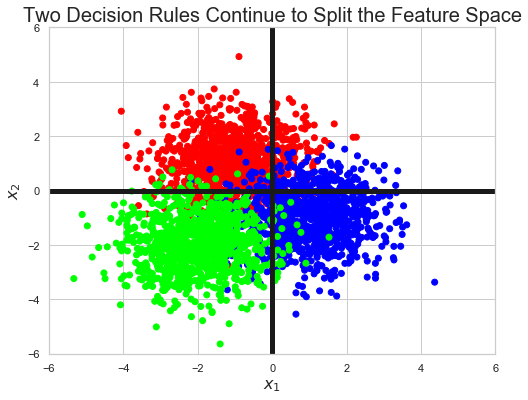

In [10]:
plt.figure(figsize = (8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'Two Decision Rules Continue to Split the Feature Space', fontsize = 20)
plt.axvline(x=0, linewidth=5, color='k')
plt.axhline(y=0, linewidth=5, color='k')

* This leads to other clear decision rules: 
    * when $x_1 < 0$ and $x_2 < 0$, declare to be **green**.
    * when $x_1 < 0$ and $x_2 > 0$, declare to be **red**.
    * when $x_1 > 0$ and $x_2 < 0$, declare to be **blue**.
    * otherwise, continue the process.

### The Random Forest (RF) Classifier

* What is a group of trees?  
    * **A forest**.  
    * If we start to split the feature space **randomly**, we have a **Random Forest**.  
    * Hence, the Random Forest classifier.  



* We can average a set of models to create an **ensemble model**.


* It is an easy classifier to implement and has become very popular, in particular in classification of massive datasets because it is easy to parallelize the process.



* In a typical setting, 100 trees works.

## Clustering: It Works in Practice
* Clustering is merely organizing the world into objects with similar features and applying labels to them.



* An object with four legs that is brown may be labelled a horse.



* A small object with four legs that is brown may be labelled a dog.



* In other words, clustering objects according to their features is second nature to humans.



### Clustering has proven to be an extraordinarily valuable tool to organize
* Two overwhelmingly successful examples:
    * The **periodic table of elements** in chemistry
    * The **standard model of particle** physics



* Clustering based on observed characteristics can, however, also be extraordinarily misleading.
    * Genetically a cow is more silimar to a whale than it is to a horse.



* In a dataframe, a cluster is a set of labels that are more similar to each other (with respect to their features) than to members of other clusters.



### In Other Words

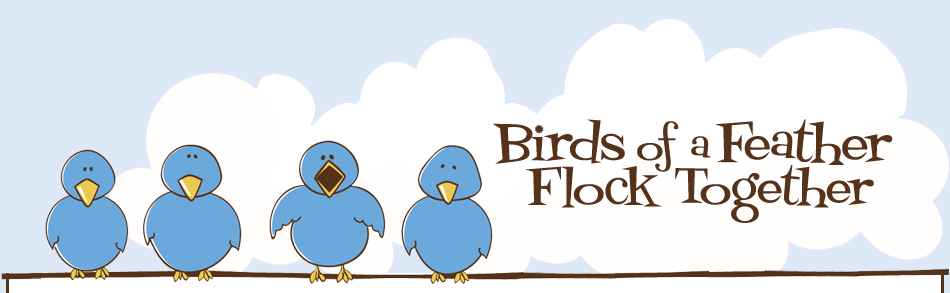

In [11]:
from IPython.display import Image
url = 'http://www.undergroundwineletter.com/wp-content/uploads/2012/01/birds-of-a-feather-cartoon.png'
Image(url, width=600, height=600)

### Consider LeCun's MNIST data.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import mnist
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

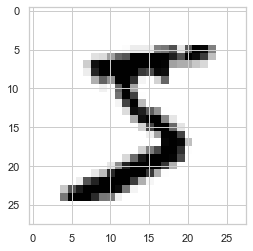

Training label(s): [5]


In [13]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

num_digits = 1
for i in range(num_digits):
    plt.subplot(1, num_digits, i+1)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray_r'))
#    plt.axis('off')
plt.show()
print('Training label(s): %s' % (y_train[0:num_digits],))

* These are grey scale images that can be converted to dataframes


* Consider the idea of placing small squares on these images. Call them 'pixels'.


* Or call them a column in an Excel spreadsheet. It is the same thing.


* The darker the pixel, the larger the value in the Excel cell.


* In a spreadsheet, the first column would be the number 5.


* Given these data are 25 X 25 pixels of grey scale: there are $25^2 + 1$ columns

> "If it can be digitized, it can be analyzed."

> Tim Savage, *CBRE Econometric Advisors Annual Client Conference*, 2016

In [14]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train_pp = (X_train.reshape(X_train.shape[0], num_pixels).astype('float32'))
print(y_train[0])
print(X_train_pp[0])

5
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.
   0

### Principal Components Analysis (PCA)

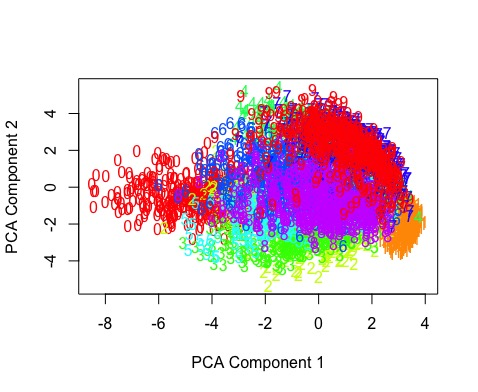

In [15]:
url = '/Users/timothysavage/Desktop/Schack Fall 2020 Real Estate Data Science/PCA with MNIST.jpeg'
Image(url, width=700, height=700)

### T-Students Stchoastic Neighbor Embedding (TSNE)

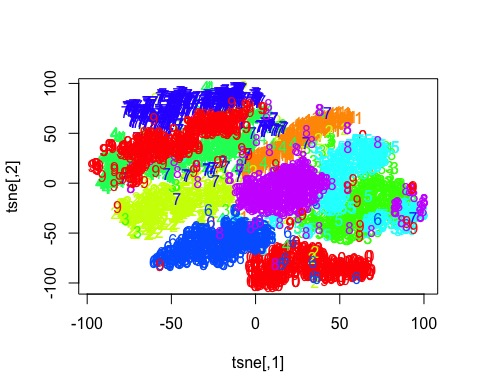

In [17]:
url = '/Users/timothysavage/Desktop/Schack Fall 2020 Real Estate Data Science/TSNE with MNIST.jpeg'
Image(url, width=700, height=700)